<a href="https://colab.research.google.com/github/slisnychyi/SergiiLisnychyiZPI_zp02Lab1_AI/blob/main/lab1_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KPI - Лісничий Сергій

# група - ЗПІ-зп01
# Технології штучного інтелекту

### Для обраного датасету (emnist) створити модель машиного навчання, навчити її на датасеті та перевірити результат на тестовій вибірці





In [9]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.11.0


Завантажемо emnist dataset. Та розділимо дані на 3 типу (**train, validaiton, test**)
* train - дані на яких ми навчаємо
* validation - набір на якому ми оцінюємо поточні результати навчання
* test - набір на кому ми фінально оцінюємо результат роботи моделі   





In [4]:
# Load EMNIST dataset
(train_data, valid_data, test_data), metadata = tfds.load('emnist',
                                                split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
                                                with_info=True)
print(metadata.features)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/3.0.0.incompleteTXEWHY/emnist-train.tfrecord*...:   0%|    …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/3.0.0.incompleteTXEWHY/emnist-test.tfrecord*...:   0%|     …

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/byclass/3.0.0. Subsequent calls will reuse this data.
FeaturesDict({
    'image': Image(shape=(28, 28, 1), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=62),
})


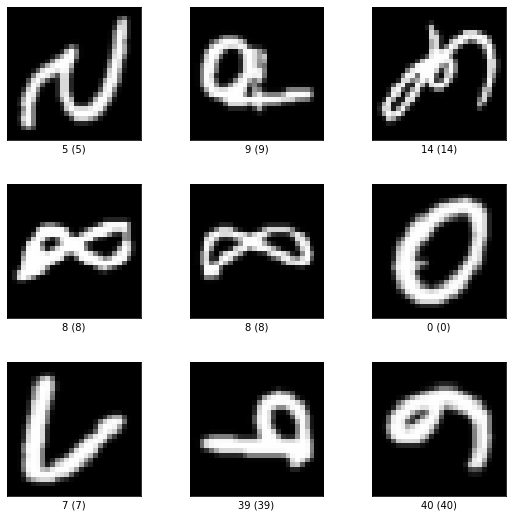

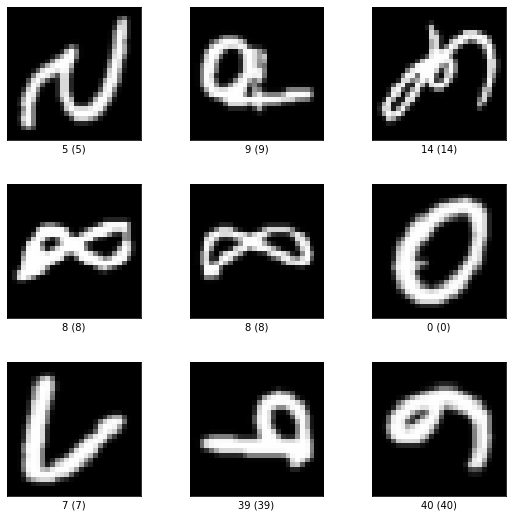

In [20]:
tfds.visualization.show_examples(train_data, metadata)

**Попередня обробка даних:**

Ми нормалізуємо значення пікселів зображень, щоб гарантувати, що вони мають однакові діапазони та розподіли. Це важливо, оскільки нейронні мережі чутливі до масштабу вхідних характеристик. Якщо вхідні характеристики мають різні масштаби, деякі функції можуть домінувати над іншими і це може вплинути на процес навчання та точність моделі.

Поділивши кожне значення пікселя на 255, ми змінюємо масштаб значень пікселів, щоб вони були між 0 і 1, що є звичайною практикою попередньої обробки зображень. Це полегшує для нейронної мережі вивчення значущих функцій із вхідних зображень і зближення до хорошого рішення.

In [5]:
def preprocess(dataset):
  image = tf.cast(dataset['image'], dtype=tf.float32) / 255
  label = tf.cast(dataset['label'], dtype=tf.float32)
  return image, label

train_data = train_data.map(preprocess).shuffle(buffer_size=1024).batch(512)
valid_data = valid_data.map(preprocess).batch(512)
test_data = test_data.map(preprocess).batch(512)


**Реалізація згорткової моделі** 

Підходить для обробки даних (зокрема зображень). 
- conv2d - фільтр класифікації. 
- maxpool - зменшує розмірність нашого зображення. 


In [6]:
def convolution_model(num_classes):
  input = tf.keras.layers.Input(shape=(28, 28, 1))
  x = tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu')(input)
  x = tf.keras.layers.MaxPool2D(2,2)(x)
  x = tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
  x = tf.keras.layers.MaxPool2D(2,2)(x)

  x = tf.keras.layers.Conv2D(16, (3,3), padding='same', activation='relu')(x)
  x = tf.keras.layers.MaxPool2D(2,2)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

  return tf.keras.models.Model(input, output, name='Classifier')

num_classes = metadata.features['label'].num_classes
model = convolution_model(num_classes)
model.summary()

Model: "Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 16)          4

**Навчання моделі**

в метод model.compile
якому ми передаємо 3 параметра
- optimizer: Adam модифікація стохастичного градієнтного спуску(з коефіціентом навчання)
- loss function: функція, що мінімізується під час навчання (яка демонтструє наскількі наша модель є невідповідною). Чим втрати менші тим краще. Використовуємо SparseCategoryCrossentropy() - оскільки ми вирішуємо задачу багатокласової класифікаії, то типовою оцінкою близкості виходу що ми отримало до бажаного є crossentropy. Інформаційний спосіб порівняння ймовірнисних величин двох розподілів.
- metrics accuracy: показник ефективності моделі. Ми використовуємо метрику точності, що показує відношення к-ті правильно класифікованих до загальної кількості. 


model.fit - навчання. При якій ми вказуємо які дані ми використовуємо, скільки буде циклів навчання та які дані використовуємо для валідації. 


In [7]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.001, 
                                               decay_steps= 100000,
                                               decay_rate=0.96)
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy']) 

history = model.fit(train_data, epochs=20, validation_data=valid_data)

Epoch 1/20
1091/1091 [==============================] - 71s 54ms/step - loss: 0.8151 - accuracy: 0.7532 - val_loss: 0.5139 - val_accuracy: 0.8280
Epoch 2/20
1091/1091 [==============================] - 55s 51ms/step - loss: 0.4875 - accuracy: 0.8314 - val_loss: 0.4503 - val_accuracy: 0.8436
Epoch 3/20
1091/1091 [==============================] - 57s 52ms/step - loss: 0.4440 - accuracy: 0.8435 - val_loss: 0.4283 - val_accuracy: 0.8476
Epoch 4/20
1091/1091 [==============================] - 56s 52ms/step - loss: 0.4225 - accuracy: 0.8492 - val_loss: 0.4094 - val_accuracy: 0.8530
Epoch 5/20
1091/1091 [==============================] - 57s 52ms/step - loss: 0.4064 - accuracy: 0.8536 - val_loss: 0.4026 - val_accuracy: 0.8542
Epoch 6/20
1091/1091 [==============================] - 56s 51ms/step - loss: 0.3959 - accuracy: 0.8566 - val_loss: 0.3953 - val_accuracy: 0.8569
Epoch 7/20
1091/1091 [==============================] - 56s 51ms/step - loss: 0.3874 - accuracy: 0.8590 - val_loss: 0.3877 -

Ми бачимо, що фунція втрат поступово зменшується. А з іншої сторони точність збільшується. Це нам вказує на правильний  процес навчання моделі. Також ми бачимо, що точність навчання на валідаційних даних зменшується у порівнянні з навчальними, хоча спочатку навіть було дещо більше. 

Після навчання моделі. Оцінюємо точність на тестових даних. 

In [8]:
metrics = model.evaluate(test_data, batch_size=512, verbose=1)
metric_names = ['test loss', 'test accurancy']

for name, value in zip(metric_names, metrics):
  print(f'{name} : {value}')

137/137 [==============================] - 7s 49ms/step - loss: 0.3760 - accuracy: 0.8619
test loss : 0.37600165605545044
test accurancy : 0.8619346022605896


Модель у графічному подані

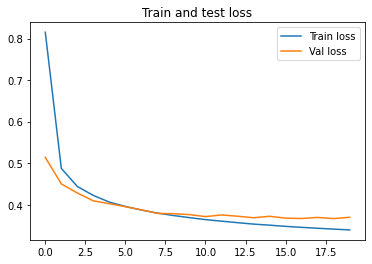

<Figure size 14400x14400 with 0 Axes>

In [10]:
plt.plot(history.history['loss'], label = 'Train loss')
plt.plot(history.history['val_loss'], label = 'Val loss')
plt.title('Train and test loss')
plt.legend()
plt.figure(figsize= (200, 200))
plt.show()

Графік відображення зміни точності моделі. 

Оцінимо ф-ію втрат. 
З ходом навчання ми бачимо, що val loss перестає зменшуватись післі n епохи. 

А навчання на тренувальних даних продовжує зменшуватись. 

Це свідчить про перенавчання нашої моделі. Модель на тренувальних даних після певного етапу продовжує навчатись тому що дані достатні комплексні та дозволяють це зробити, однак враховуючи валідаційні дані ми не потребуємо у більш детальному підналаштовувані(тренуванні). 

Наша задача, щоб валідаційні та тренувальні дані були більш менш на одному рівні. 



Основні підходи до боротьби:
- технічні методи регуляризації (зупинити перенавчання)

в коді можна додати 
tf.keras.layers.Dropout(0.5)(x)
ми випадковим чином під час навчання будемо вимикати окремі нейрони з вірогідністю 0.5. В даному випадку можель стає простіше і інші нейрони тепер починають бути більш задіяні. Техніка покразення процесу навчання.


- змінити саму модель (наприклда зменшити шари)

Epoch 1/20
1091/1091 [==============================] - 61s 54ms/step - loss: 0.9221 - accuracy: 0.7254 - val_loss: 0.5061 - val_accuracy: 0.8286
Epoch 2/20
1091/1091 [==============================] - 57s 52ms/step - loss: 0.5406 - accuracy: 0.8161 - val_loss: 0.4484 - val_accuracy: 0.8442
Epoch 3/20
1091/1091 [==============================] - 58s 53ms/step - loss: 0.4964 - accuracy: 0.8278 - val_loss: 0.4264 - val_accuracy: 0.8469
Epoch 4/20
1091/1091 [==============================] - 58s 53ms/step - loss: 0.4729 - accuracy: 0.8343 - val_loss: 0.4126 - val_accuracy: 0.8516
Epoch 5/20
1091/1091 [==============================] - 57s 52ms/step - loss: 0.4575 - accuracy: 0.8387 - val_loss: 0.4020 - val_accuracy: 0.8563
Epoch 6/20
1091/1091 [==============================] - 57s 52ms/step - loss: 0.4451 - accuracy: 0.8418 - val_loss: 0.3958 - val_accuracy: 0.8559
Epoch 7/20
1091/1091 [==============================] - 57s 52ms/step - loss: 0.4364 - accuracy: 0.8442 - val_loss: 0.3922 -

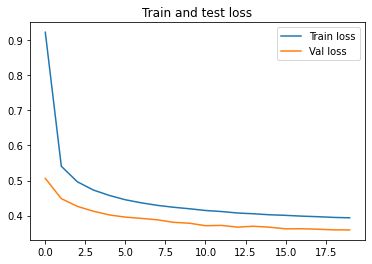

<Figure size 14400x14400 with 0 Axes>

In [13]:
def convolution_model(num_classes):
  input = tf.keras.layers.Input(shape=(28, 28, 1))
  x = tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu')(input)
  x = tf.keras.layers.MaxPool2D(2,2)(x)
  x = tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
  x = tf.keras.layers.MaxPool2D(2,2)(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Conv2D(16, (3,3), padding='same', activation='relu')(x)
  x = tf.keras.layers.MaxPool2D(2,2)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

  return tf.keras.models.Model(input, output, name='Classifier')

num_classes = metadata.features['label'].num_classes
model = convolution_model(num_classes)
# model.summary()

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.001, 
                                               decay_steps= 100000,
                                               decay_rate=0.96)
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy']) 

history = model.fit(train_data, epochs=20, validation_data=valid_data)

metrics = model.evaluate(test_data, batch_size=512, verbose=1)
metric_names = ['test loss', 'test accurancy']

for name, value in zip(metric_names, metrics):
  print(f'{name} : {value}')

plt.plot(history.history['loss'], label = 'Train loss')
plt.plot(history.history['val_loss'], label = 'Val loss')
plt.title('Train and test loss')
plt.legend()
plt.figure(figsize= (200, 200))
plt.show()

Оцінка результатів:
За результатами проведеного моделювання можна зробити висновок, що модель навчається правильно. На навчанні моделі без застосування методу регуляризації бачимо, що функція на валідаційних данних дешо не однорідна, що вказує на складність самої моделі. Після застосування методу регуляризації. Стало менше викидів та точність на валідаційних даних стала навіть вища ніж на тестових даних. Що свідчить про можливо недостатню к-ть епох навчання. 

